In [12]:
from fastai.collab import *
from fastai.tabular.all import *
set_seed(42)

In [13]:
path = untar_data(URLs.ML_100k)

In [14]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header = None,
names = ['user', 'movie','rating','timestamp'])

ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [15]:
last_skywalker = np.array([0.98, 0.9, -0.9])

In [16]:
user1 = np.array([0.9, 0.8, -0.6])

In [17]:
(user1*last_skywalker).sum()

2.1420000000000003

Learning the Latent Factors


In [20]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding = 'latin-1',
usecols=(0,1), names = ('movie','title'), header=None)

movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


In [21]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)


In [22]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,782,Starship Troopers (1997),2
1,943,Judge Dredd (1995),3
2,758,Mission: Impossible (1996),4
3,94,Farewell My Concubine (1993),5
4,23,Psycho (1960),4
5,296,Secrets & Lies (1996),5
6,940,"American President, The (1995)",4
7,334,Star Trek VI: The Undiscovered Country (1991),1
8,380,Braveheart (1995),4
9,690,So I Married an Axe Murderer (1993),1


In [23]:
n_users = len(dls.classes['user'])
n_movies = len(dls.classes['title'])
n_factors = 5

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [25]:
one_hot_3 = one_hot(3, n_users).float()

In [26]:
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [27]:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

Collaborative Filtering from Sratch

In [31]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

In [32]:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

In [33]:
model = DotProduct(n_users, n_movies, 50)

learn = Learner(dls, model, loss_func=MSELossFlat())

In [34]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.328333,1.334180,00:09
1,1.031692,1.081094,00:12
2,0.888723,0.980787,00:11
3,0.767330,0.904176,00:12
4,0.755589,0.884019,00:14


In [35]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [36]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [37]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func = MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.914850,0.984576,00:12
1,0.653909,0.935353,00:10
2,0.453693,0.934652,00:10
3,0.374656,0.942871,00:11
4,0.333484,0.939626,00:10


In [38]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [39]:
model = DotProductBias(n_users, n_movies,50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.824824,0.929579,00:10
1,0.606336,0.918154,00:11
2,0.388497,0.950811,00:11
3,0.311393,0.962623,00:11
4,0.302112,0.964192,00:11


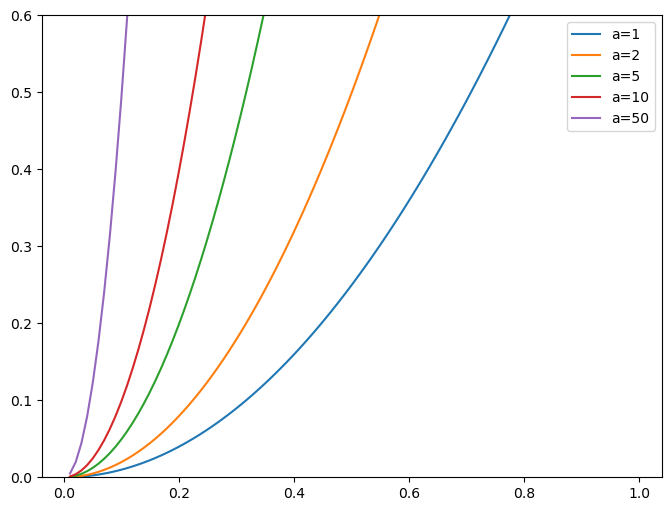

In [40]:
x = np.linspace(0.01,0.99,100)
a_s = [1,2,5,10, 50]
ys = [a* x**2 for a in a_s]
_, ax = plt.subplots(figsize=(8,6))
for a,y in zip(a_s,ys): ax.plot(x,y, label=f'a={a}')
ax.set_ylim(0,0.6)
ax.legend();

In [42]:
model = DotProductBias(n_users, n_movies,50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.907713,0.955555,00:13
1,0.686926,0.892041,00:13
2,0.530543,0.865177,00:11
3,0.451494,0.849145,00:11
4,0.433333,0.845423,00:11


In [44]:
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

In [45]:
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

In [46]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.903126,0.942074,00:13
1,0.649169,0.890997,00:12
2,0.529146,0.871970,00:12
3,0.454915,0.862031,00:13
4,0.418749,0.856267,00:16


In [47]:
model_bias = learn.model.movie_bias.squeeze()
idxs = model_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Grease 2 (1982)',
 'Showgirls (1995)',
 'Leave It to Beaver (1997)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Spice World (1997)']

In [48]:
idxs = model_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Shawshank Redemption, The (1994)',
 'Titanic (1997)',
 'Good Will Hunting (1997)',
 "Schindler's List (1993)",
 'Rear Window (1954)']

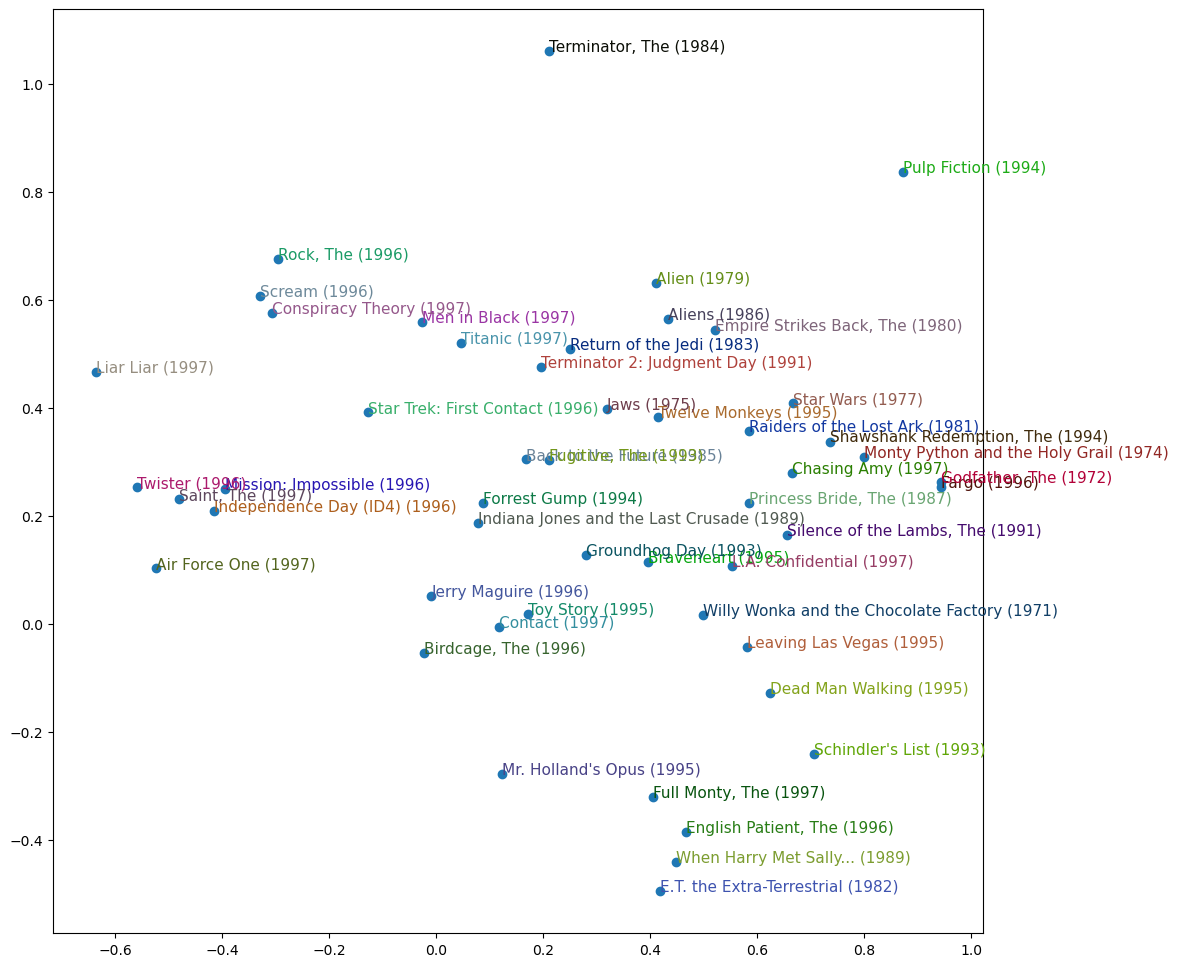

In [50]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]

plt.figure(figsize=(12,12))
plt.scatter(X,Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

In [51]:
learn = collab_learner(dls, n_factors = 50, y_range = (0, 5.5))

In [52]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.901709,0.940396,00:12
1,0.689448,0.882384,00:11
2,0.527743,0.861637,00:12
3,0.451937,0.852570,00:14
4,0.438466,0.849472,00:12


In [53]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

In [54]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending = True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Rear Window (1954)',
 "Schindler's List (1993)",
 'Shawshank Redemption, The (1994)',
 'Boot, Das (1981)']

In [55]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending = True)[1]
dls.classes['title'][idx]

'Meet John Doe (1941)'

In [56]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [57]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range

    def forward(self, x):
        embs = self.user_factors(x[:,0]), self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

In [58]:
model = CollabNN(*embs)

In [59]:
learn = Learner(dls, model, loss_func = MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd = 0.01)

epoch,train_loss,valid_loss,time
0,0.945434,0.945818,00:16
1,0.849261,0.911785,00:15
2,0.849229,0.878854,00:15
3,0.773977,0.857463,00:19
4,0.773312,0.860195,00:15


In [61]:
learn = collab_learner(dls, use_nn = True, y_range=(0,5.5), layers = [100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time


In [62]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)
        